In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.circuit import Delay

import sys
import os

sys.path.append(os.path.abspath("..\\..\\..\\.."))
from metrics.IBM.get_calibration_data import get_calibration_data, get_best_qubits



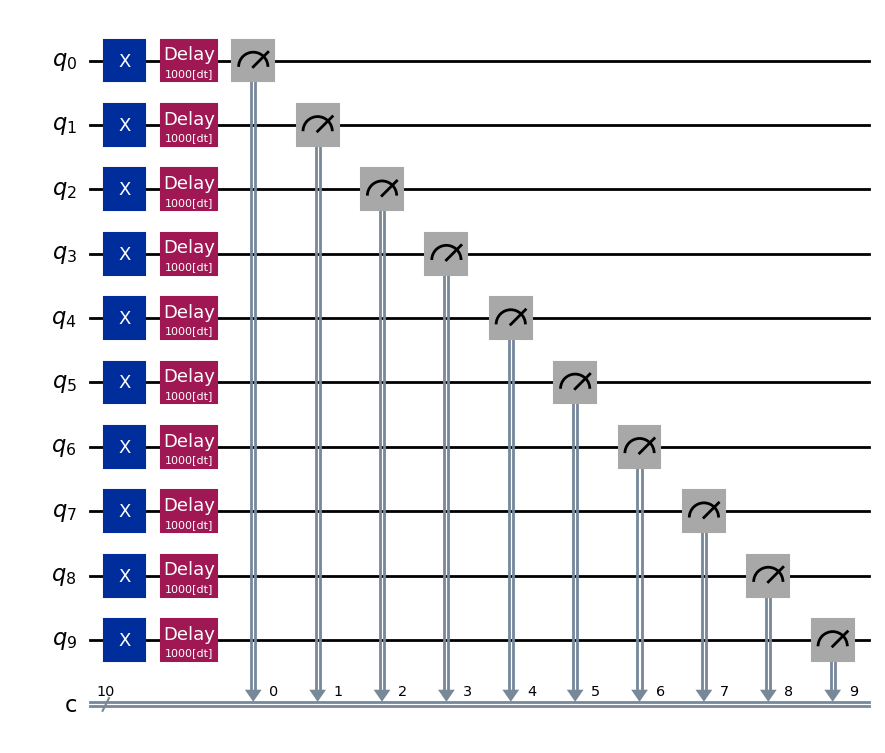

In [5]:
def load_circuit(delay, qb_len=1):
    qc = QuantumCircuit(qb_len, qb_len)

    qc.x(range(qb_len)) # estado inicial 1
    for i in range(qb_len):
        qc.append(Delay(delay), [i])
    qc.measure(range(qb_len), range(qb_len))

    return qc

qc = load_circuit(1000, 10)
qc.draw('mpl')



In [6]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_kyiv")
data_csv = 'ibm_kyiv_calibrations_2024-12-15T18_46_41Z.csv'

In [7]:
best_T1_qubits = get_best_qubits(data_csv, lambda x: x.T1, 10)
print(*[f"{q.Qubit}, T1={round(q.T1, 3)}" for q in best_T1_qubits], sep= '\n')

9, T1=495.303
7, T1=495.238
20, T1=472.023
77, T1=447.75
21, T1=443.357
47, T1=437.438
12, T1=436.794
108, T1=435.343
31, T1=423.071
39, T1=420.329


In [8]:
isa_circuit = transpile(qc, backend, scheduling_method="asap", optimization_level=3, initial_layout=[q.Qubit for q in best_T1_qubits])
print(f"Circuit Depth: {qc.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
# isa_circuit.draw(output='mpl')

Circuit Depth: 3
Transpiled Circuit Depth: 3


In [9]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [1]:
t_array = [0, 40_000, 80_000, 120_000, 160_000, 200_000, 240_000, 280_000, 320_000, 360_000, 400_000,
           440_000, 480_000, 520_000, 560_000, 600_000, 640_000, 680_000, 720_000, 760_000, 800_000]


In [2]:
print(len(t_array))

21


In [ ]:

# circuits = []

# for t in t_array:

#     qc = load_circuit(t, qb_len=10)

#     isa_circuit = transpile(qc, backend, scheduling_method="asap", optimization_level=3, initial_layout=[q.Qubit for q in best_T1_qubits])
#     circuits.append(isa_circuit)

#     print(f"Circuit Depth: {circuits[-1].depth()}")
#     print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} μs")
#     print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
#     # c.draw(output='mpl')

In [17]:
sampler = SamplerV2(backend=backend)
shots = 100
# job = sampler.run(circuits, shots=shots)
job = service.job('cxfkwvbfdnwg008s8yxg')
pub_result = job.result()

In [18]:
import numpy as np

# print("error rate:")

results = []

for i in range(len(t_array)):
    result = pub_result[i]
    meas = result['__value__']['data']['c'].get_counts()
    
    qubit_results = {}

    # print(f"@ {t_array[i]*dt/1000}μs")

    for q in range(10):
        qubit_results[q] = {
            '0': np.sum([meas[r] for r in meas if r[9-q] == '0']),
            '1': np.sum([meas[r] for r in meas if r[9-q] == '1']),
        }

        # print(f"\t > {qubit_results[q]['1']}%")
    # print(*[f"\t {round(qubit_results[q]['1'])}%" for q in range(10)])

    results.append(qubit_results)

    # print(qubit_results)

    

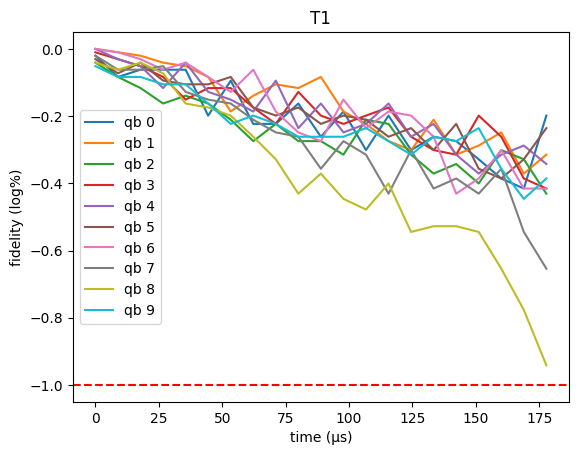

In [19]:
import matplotlib.pyplot as plt
import math

# Example data arrays
x = [t*dt/1000 for t in t_array]
y = [[np.log((r[q]['1'])/100) for r in results] for q in range(10)]

plt.axhline(y=-1, color='r', linestyle='--')

# Create the plot
for q in range(10):
    plt.plot(x, y[q], label=f'qb {q}')

# Add labels and title
plt.xlabel('time (μs)')
plt.ylabel('fidelity (log%)')
plt.title('T1')
plt.legend()

# Display the plot
plt.show()

T1

In [20]:
def get_layout(circuit, qb_len=1):
    layout = circuit._layout.initial_layout.get_virtual_bits()
    keys = [layout[i] for i in layout]
    return keys[:qb_len]

# for c in circuits:
#     get_layout(c, qb_len=10)

data_qubits, data_edges = get_calibration_data(data_csv)

# layout = get_layout(circuits[0], qb_len=10)
layout = [q.Qubit for q in best_T1_qubits]

# print(layout)

# print(*[round(data_qubits[q].T1, 2) for q in layout], sep='\n')

In [21]:

print(f"qubit \t | T1 estimation (μs) \t | T1 by IBM data (μs) \t | variation")
print("--------------------------------------------------------------------")

for q in range(10):

    # log_y = [np.log(y_t) for y_t in y[q]]
    log_y = y[q]

    T1 = - np.sum([x_i**2 for x_i in x]) / np.sum([x[i]*log_y[i] for i in range(len(x))])
    T1_std = np.sqrt(1/len(x) * np.sum([(-x[i]/T1 - log_y[i])**2 for i in range(len(x))]))
    T1_data = data_qubits[layout[q]].T1

    print(f"{q}->{layout[q]} \t | {round(T1, 2)} \t\t | {round(T1_data, 2)} \t\t | {round((T1/T1_data-1)*100)}%")
    print("--------------------------------------------------------------------")

        #   , std = {round(T1_std, 2)}")

qubit 	 | T1 estimation (μs) 	 | T1 by IBM data (μs) 	 | variation
--------------------------------------------------------------------
0->9 	 | 465.69 		 | 495.3 		 | -6%
--------------------------------------------------------------------
1->7 	 | 520.34 		 | 495.24 		 | 5%
--------------------------------------------------------------------
2->20 	 | 399.94 		 | 472.02 		 | -15%
--------------------------------------------------------------------
3->77 	 | 486.49 		 | 447.75 		 | 9%
--------------------------------------------------------------------
4->21 	 | 492.02 		 | 443.36 		 | 11%
--------------------------------------------------------------------
5->47 	 | 491.05 		 | 437.44 		 | 12%
--------------------------------------------------------------------
6->12 	 | 446.07 		 | 436.79 		 | 2%
--------------------------------------------------------------------
7->108 	 | 326.45 		 | 435.34 		 | -25%
--------------------------------------------------------------------
8->31 	 | 2